<div style="padding:20px;color:#6A79BA;margin:0;font-size:180%;text-align:center;display:fill;border-radius:5px;background-color:white;overflow:hidden;font-weight:600">Inteligencia Artificial para la Predicción de Incremental de Presiones por Interferencia</div>

<img src="https://metadata.fundacionsadosky.org.ar/media/media/images/YPF_-_sitio_WEB.png" style="border-radius:5px">

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">1 | Introducción</div>

## Descripción del problema

Una de las características asociadas a la producción de petróleo y gas no convencional es la necesidad de estimular los pozos productores antes del comienzo de la producción. La estimulación consiste en la generación de fisuras en la roca productora a través de la inyección de un fluido a alta presión.

El avance sistemático de los desarrollos no convencionales en la Fm. Vaca Muerta implica la perforación de pozos horizontales distribuidos espacialmente con el objetivo de maximizar la recuperación de petróleo y gas. Con ese objetivo, la distancia entre pozos vecino ha ido disminuyendo a lo largo del tiempo y, como consecuencia, se han registrado interferencias entre los pozos en producción (pozos padres) y los pozos nuevos en estimulación (pozos hijos) denominados frac-hits.

Los frac-hits consisten en una anomalía de presión, corte de agua y/o temperatura en un pozo productor vecino a un pozo que está siendo fracturado. Este suceso de denomina "golpe de fractura" o "frac-hit" debido a que las fracturas hidráulicas del pozo hijo "golpean" el volumen de reservorio estimulado por el pozo padre y generan la interconexión.

Este fenómeno, se ha convertido en una importante preocupación debido a que constituye un riesgo para las operaciones, debido a las condiciones de integridad del pozo padre como colapso de casing, fugas de fluido por el cabezal de pozo, aprisionamiento de instalaciones de producción.

La pérdida de integridad de un pozo padre trae aparejado un importante costo debido a los riesgos de seguridad que conlleva, la posible detención de sets de fractura, costos de remediación y costo de oportunidad de equipos que se destinan a asegurar pozos padres. Por lo tanto, se requiere desarrollar un modelo predictivo que permita identificar los pozos con riesgo a ser interferidos y la magnitud de los frac-hits asociados.

En este contexto, **el objetivo del concurso actual es el desarrollo de un algoritmo de predicción de incremento de presión (delta_WHP)** como consecuencia de todos los frac-hits que pueda recibir un pozo padre a raíz de la estimulación de un conjunto de pozos hijos cercanos.

El alcance del modelo es para pozos productores en Yacimientos No Convencionales de Petróleo y Gas.

Para mas detalles sobre los files y la descripción del problema ir a este [link](https://metadata.fundacionsadosky.org.ar/competition/29/)

## Método de Evaluación

Si bien en la descripción original del problema encontramos el siguiente texto:

*Se busca optimizar los pozos que ingresan al protocolo de aseguramiento, minimizando dos tipos de pozos: los pozos no asegurados que son interferidos y los pozos asegurados que no son interferidos. El resultado mejora la gestión de los riesgos que se asume y optimizando los costos de lifting asociados.*

Luego a través de la competencia vemos que la métrica utilizada fue [*Mean absolute error (MAE)*](https://en.wikipedia.org/wiki/Mean_absolute_error)



# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">2 | Evolución de la solución</div>

En esta sección describiremos el proceso transitado durante la competencia y las sucesivas marchas y contramarchas dentro de la competencia.

- Submit 1

Luego de un análisis exploratorio incial (pandas profiling + algunas distribuciones de la variable target) se probo un baseline con todos los delta en 0 (1.21) para tener un score de referencia

- Submit 2

Teniendo a ese momento como métrica de referencia el MSE y estando en una etapa puramente exploratoria se busco la completitud por medias para los pads con mayor delta que la media del dataset, esto mejoraba el MSE pero empeoró el lb (1.46)

- Submit 3

Data leakeage, luego del workshop se aclaró q las etapas tienen un orden cronológico y que la data de evaluación se habia extraído de forma aleatoria, por lo cual se jugo con variables de etapas posteriores para estimar el delta, nuevamente mejoraba el MSE  pero no el lb (1.41), acá se valido que la métrica utilizada en el lb es el MAE y se empezó a utilizar para medir mejoras

- Submit 4

Se utilizó el primer modelo predictivo, se utilizó [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.1/) que es un algoritmo de gradient boosting muy popular para este tipo de problemas. Sin ningun tipo de feature enginnering (de ahora en mas fe) adicional al que ya se tenía, spliteando 80/20 para tener un set de validación, y luego entrenando con la totalidad de la data y el número de iteraciones obtenida contra esa validación. Ahí ya utilizando MAE en validación daba 1.22 y en el lb se consiguió un puntaje de 0.90 obteniendo mejora significativa

- Submits 5,6,7

Se empezaron a crear funciones de fe, y esto trajo errores en el script. La función inicialmente no tenia el sort indicado sobre los registros para que el cálculo de las variables shifted diera de forma correcta por lo cual se obtuvieron dos submits fallidos.

Una vez detectado y solucionado este error el modelo agregaba algunas variables de la etapa anterior y una variable que sale de obtener una distancia jugando con ángulos y distancias (ver función de variables trigonométricas), esto daba una sutil mejora en validación (1.21) pero empeoraba en el lb (0.94).

- Submits 8,9,10

Sin mejoras, se crearon variables relativas a la etapa (ver función stage_vars), se fixearon bugs en el script respecto de esas variables (problemas con train, validation y test flags), y se probo variable max_delta_last_3, mejora en validacion score (1.08) pero no en lb (0.93113)

- Submit 11

Jugando con variable ID_FILA, pensando erróneamente que podía aportar info del orden de los sucesos, empeoraba en validación (1.30) y tambien en lb (1.14).

Mucho tiempo dedicado a tratar de reconstruir la linea temporal de un pozo padre (ordenar las interacciones de los pozos hijos) sin éxito.

- Submit 12

Abandonada la idea de rearmar el flujo de alteraciones se generan variables futuras que son de peso para la mejora como:
    *max_delta_next_6*,
    *mean_delta_next_6*,
    *next_pressure_relation*

Dando en validation 0.8264 y en lb 0.86 (septimo hasta el momento)

- Submit 13

Con el análisis de scores con mayor error identificamos que la variable estimated_delta funciona mejor sin el setup adicional que se le estaba poniendo (setear en 0 para algunos casos particulares), ya que estos son incorporados a traves del modelo por otras variables y esas diferencias aportaban informacion. Se logro un score de validacion de 0.79 y en lb 0.83 (sexto hasta el momento)

- Submit 14

Funcion *get_dad_vars* con variables asociadas al pozo padre, es decir tomamos todas las interacciones para ese pozo, las ordenamos por presion inicial ascendente (esto deja de tomar a la etapa como factor de orden) y calcula métricas como el max, mean y mediana de esos deltas, esto da un score de 0.79 en validacion y 0.82 en lb

- Submit 15

Se agregaro a *get_dad_vars* la funcion de cálculo rolling forward obteniendo el mejor puntaje de validación hasta el momento 0.60, lamentablemente dio mucho peor en el lb 1.02. Se estima que es un problema de overfitting sobre el set de validación que aún no se puede corregir.

- Submit 16

Buscando la razón del error del submit anterior, se encuentra que en todo el script se está ordenando por:

*['FLUIDO', 'CAMPO', 'PAD_HIJO', 'PADRE', 'HIJO', 'ETAPA_HIJO']*

Y se cambia tomando las variables enteras de dichas segmentaciones, ya que el nombre de pad y pozo puede significar un orden temporal:

*['FLUIDO', 'CAMPO', 'PAD_HIJO_int', 'PADRE_int', 'HIJO_int', 'ETAPA_HIJO']*

esto da un mae de validación de 0.79 (seguimos sin movernos aca) pero un puntaje en lb de 0.81 (sexto hasta el momento)

- Submit 17

Se probaron variables como Tramo (una variable creada a traves del ID FILA para determinar alguna información extra del armado de la data) sin resultados.

También se trato de estimar el WHP_i de una estapa posterior con una regresión de grado n, obteniendo peores resultados.

Se analizan las predicciones en función de la métrica, las estimaciones cercanas a cero (<2.5) se pasan a 0 y esto mejora mucho el MAE en validacion de 0.79 a 0.73, lo mismo en el lb 0.74574 (primero hasta el momento!)

- Submits 18,19,20

Sin mejoras, se probaron algunos intentos de calculos sobre variables de etapas futuras sin éxito, también se optimizaron parámetros de lightgbm que dieron mejoras en validación (0.783) pero no en lb (0.754)

- Submit 21

Cambio de cálculo de variables en validación, se pasa delta_WHP a None previo a los cálculos de variables y se obtiene peor puntaje en validacion (0.929) pero confiando en un set de validación más estable, este intento dio 0.752 en lb

- Submit 22

Creación de la variable *estimated_next_delta2*, la misma toma como referencia la siguiente presión mas grande para ese pozo padre (considerando todos los hijos) y con esa presión calcula el delta estimado. Difiere de *estimated_next_delta* porque esta última solo ve la presión inicial de la siguiente etapa de cada pozo hijo.

Luego de generar esta variable la validación mejora a 0.9123 y en lb se va a 0.7178 (muy cerquita del primer puesto)

- Submit 23

Creación de variables relacionando factores entre las mas importantes, ejemplos son +max_delta_prev_next_3_rel*,*mean_delta_prev_next_6_rel* y *max_delta_prev_next_6_rel* la mejora en cv era marginal (0.9119), y en lb empeoro un poco (0.7199), submit solo de ambicioso

- Submit 24

Saco de *get_dad_vars* el ordenamiento por fluido y pad-hijo esperando mejoras, obtengo mejora marginal en validation (0.9116) y empeora en lb (0.7332)

- Submit 25

Se prueba usar Padre, Hijo y Pad como enteros mejora en validacion (0.9096) pero no en lb (0.746) estamos muy fino ya midiendo mejoras sobre el set de test

- Submit 26

Se prueba mejorar la optimización del corte para el fix de ceros, buscando variaciones por campo, numero de pozo padre e hijo y pad, buscando determinar temporalmente si la proporción de deltas mayor a cero crecia. Sin mejoras significativas en validación da peor en lb (0.720)

- Submit 27

 Creo nueva variable *delta_WHP_max* y refloto variables *delta_WHP_mean* y *delta_WHP_median*, las mismas son calculadas sobre toda la distribución del hijo (excluyendo los puntos del set de validación), anteriormente sustituidas por las rolling historicas (en ese caso tenia spliteadas las pasadas y las futuras). Se ve mejora en validacion (0.893) y su corresponiente mejora en lb (0.675), primer puesto hasta el momento!

 Creo que el seguir insistiendo en tener un set de validación confiable es parte del éxito de esta competencia en particular

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">3 | Obteniendo Data</div>


Variables de configuracion de la notebook

In [1]:
# Solo en caso de querer correr el optimizador de parametros, los conseguidos ya estan guardados
# No se asegura con este parámetro en true que el resultado sea idéntico
TUNE_PARAMETERS = False
# Para cambiar los paths de files
RUN_IN_COLAB = True

In [2]:
import math
import warnings
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sys import displayhook

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

In [3]:
if RUN_IN_COLAB:
    drive.mount('/content/drive')
    root_folder = '/content/drive/MyDrive/202210-YPF/'
    %cd '/content/drive/MyDrive/202210-YPF/'
    %pip install -r requirements.txt
else:
    root_folder = '../'

submission_folder = root_folder + 'submissions/'
data_folder = root_folder + 'data/'
version = 'v30'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/202210-YPF
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Ignoring appnope: markers 'sys_platform == "darwin" and python_version >= "3.8" and platform_system == "Darwin"' don't match your environment
Ignoring attrs: markers 'python_version >= "3.8"' don't match your environment
Ignoring autopage: markers 'python_version >= "3.8"' don't match your environment
Ignoring backcall: markers 'python_version >= "3.8"' don't match your environment
Ignoring cffi: markers 'implementation_name == "pypy" and python_version >= "3.8"' don't match your environment
Ignoring cliff: markers 'python_version >= "3.8"' don't match your environment
Ignoring cmd2: markers 'python_version >= "3.8"' don't match your environment
Ignoring colorama: markers 'python_version >= "3.8" and python_full_version < "3.0.0

In [4]:
def read_data():
    train_df = pd.read_csv(
        data_folder + 'Dataset participantes.csv',
        encoding='utf-16le',
        sep='\t',
        decimal='.',
    )
    train_df['type'] = 'Train'
    eval_df = pd.read_csv(data_folder + 'Dataset evaluación.csv')
    eval_df['type'] = 'Test'
    eval_df['delta_WHP'] = None
    eval_df['WHP_i'] = eval_df['WHP_i'].replace(',', '.', regex=True).astype(float)
    eval_df['D3D'] = eval_df['D3D'].replace(',', '.', regex=True).astype(float)

    df = pd.concat([train_df, eval_df])
    df = df.reset_index(drop=True)
    df['delta_WHP'] = df['delta_WHP'].astype(float)
    return train_df, eval_df, df.copy()


train_df, eval_df, df = read_data()


# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">4 | Análisis Exploratorio</div>

Número de casos del set de entrenamiento

In [5]:
train_df.shape[0]

26178

Como bien se describe en la definicion del problema los atributos aportados son:

- ID_FILA: Identificador usado para subir la solución.
- ID_EVENTO: Identificador único de la línea.
- CAMPO: Nombre del Bloque al que pertenece el PAD Hijo.
- FLUIDO: Fluido que produce el PAD (Gas o Petróleo).
- PAD_HIJO: Nombre del PAD Hijo: HIJO: Nombre del Pozo Hijo.
- ETAPA_HIJO: Número de Etapa de Fractura del pozo Hijo.
- PADRE: Nombre del Pozo Padre.
- D3D: Distancia tridimensional entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre (DX^2+DY^2+DZ^2)/2.
- D2D: Distancia en planta (vista de pajaro - sin considerar distancia vertical) entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre (DX^2+DY^2)*(1/2).
- DZ: Distancia vertical (diferencia de altura) entre la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre.
- AZ: Angulo respecto al norte que forma la linea recta que une la etapa de fractura del Pozo Hijo y la etapa de fractura más cercana del Pozo Padre.
- #_BARRERAS: Cantidad de pozos padre entre el Pozo Hijo y el Pozo Padre considerado. Se consideran todos los pozos atravesados por la linea considerada en la D2D, y - dentro de un espacio vertical que abarca toda la distancia vertical entre Pozo Hijo y Pozo Padre más 40m por encima y por debajo.
- LINEAMIENTO: Anomalías geológicas que atraviesan al Pozo Hijo y Pozo Padre.
- WHP_i: Presión al inicio de la interferencia.
- delta_WHP: Salto de presión generado por la interferencia. Desde la presión inicial al punto máximo o mínimo del salto.
- ESTADO: Estado del pozo al momento de la interferencia. Cerrado/Abierto.

Primeras filas del set de datos:

In [6]:
displayhook(df.head())

ID_FILA             ID_EVENTO    CAMPO FLUIDO PAD_HIJO      HIJO  \
0        1    Pozo 81-Pozo 22-37  Campo D    OIL   PAD-47   Pozo 81   
1        2  Pozo 132-Pozo 112-10  Campo C    GAS   PAD-19  Pozo 132   
2        3  Pozo 133-Pozo 112-21  Campo C    GAS   PAD-19  Pozo 133   
3        4   Pozo 478-Pozo 122-6  Campo C    GAS   PAD-21  Pozo 478   
4        5  Pozo 405-Pozo 242-19  Campo F    OIL   PAD-60  Pozo 405   

   ETAPA_HIJO     PADRE      D3D      D2D     DZ      AZ  #_BARRERAS  \
0          37   Pozo 22 1323.623 1323.213 32.961 199.623           0   
1          10  Pozo 112 1184.249 1184.233  6.081 345.026           0   
2          21  Pozo 112  847.812  847.771  8.313 342.172           0   
3           6  Pozo 122  625.328  625.315  4.139 259.131           1   
4          19  Pozo 242 1118.215 1118.074 17.717  90.993           3   

  LINEAMIENTO  WHP_i  delta_WHP   ESTADO   type  
0          NO -0.200      0.000  Abierto  Train  
1          NO -0.100      0.000  Abierto  Train  
2          NO -0.100      0.000  Abierto  Train  
3          NO -0.100      0.000  Abierto  Train  
4          NO -0.100      0.000  Abierto  Train

Ordenamos la data para verla por etapas en cada hijo

In [7]:
df = df.sort_values(by=['FLUIDO', 'CAMPO', 'PAD_HIJO', 'PADRE', 'HIJO', 'ETAPA_HIJO'])

### Análisis de la variable objetivo: delta_WHP

Como lo dice la descripción de la variable, cada interferencia sobre un pozo hijo puede generar (o no) un delta de presión sobre el pozo padre indicado, esta variable refleja ese estado. 

Veamos su distribución:

In [8]:
displayhook(train_df['delta_WHP'].describe())
px.box(train_df['delta_WHP'], width=400, height=400)

count   26178.000
mean        1.376
std         7.574
min       -90.000
25%         0.000
50%         0.000
75%         0.000
max       212.800
Name: delta_WHP, dtype: float64

Observamos varias cosas:
- que la variable tiene como valor 0 predominantemente,
- en la data de entrenamiento tiene una media de 1.376
- hay tanto incrementos como decrementos de presión

In [9]:
print(train_df.groupby(train_df['delta_WHP'] == 0).size() / train_df.shape[0] * 100)

delta_WHP
False   11.938
True    88.062
dtype: float64


> En concreto el 88% de los registros son 0

Armemos un modelo baseline con todos los registros en 0

In [10]:
baseline0 = df.loc[df.type == 'Test', ['ID_FILA', 'delta_WHP']]
baseline0['delta_WHP'] = 0.0
baseline0.to_csv(submission_folder + 'baseline0.csv', index=False, header=False)

> Este modelo da un score de 1.23481

In [11]:
def mse_ceros(df):
    print("MSE para ceros:")
    print(mean_squared_error(df.loc[df.type == 'Train', 'delta_WHP'], np.zeros(26178)))

    print("MAE para ceros:")
    print(mean_absolute_error(df.loc[df.type == 'Train', 'delta_WHP'], np.zeros(26178)))


mse_ceros(df)

MSE para ceros:
59.25536557414624
MAE para ceros:
1.4479028191611276


> Calculando los scores en train para un set de ceros vemos que el resultado se asemeja a la métrica MAE

Distribución de deltas distintos de cero

In [12]:
condition = train_df['delta_WHP'] != 0
displayhook(train_df.loc[condition, 'delta_WHP'].describe())
px.box(train_df.loc[condition, 'delta_WHP'], width=400, height=400)

count   3125.000
mean      11.524
std       19.071
min      -90.000
25%        1.900
50%        5.200
75%       13.300
max      212.800
Name: delta_WHP, dtype: float64

In [13]:
px.histogram(train_df.loc[condition, 'delta_WHP'])

Observaciones:
- Tenemos 3125 interferencias (delta distinto de cero)
- Dentro de las estimulaciones que generaron deltas de presión, podemos hallar en un rango esperado a deltas entre -15.1 y 30.2, por fuera de esto ya tenemos outliers de variación (casos poco comunes).
- El 50% de los casos donde hay interferencia la misma esta entre 1.9 y 13.3 de magnitud
- 358 interferencias (11.5%) tienen un valor absoluto menor a 1

### Campo vs Fluido

Valores únicos de ambos campos:

In [14]:
displayhook(list(df.CAMPO.unique()))
displayhook(list(df.FLUIDO.unique()))

['Campo A',
 'Campo C',
 'Campo G',
 'Campo I',
 'Campo B',
 'Campo D',
 'Campo E',
 'Campo F',
 'Campo H']

['GAS', 'OIL', nan]

Veamos como se relacionan:

In [15]:
df.groupby(['CAMPO', 'FLUIDO']).agg(
    {'PADRE': 'nunique', 'HIJO': 'nunique', 'type': ['min', 'max']}
)

PADRE    HIJO  type       
               nunique nunique   min    max
CAMPO   FLUIDO                             
Campo A GAS          6       7  Test  Train
Campo B OIL         57      30  Test  Train
Campo C GAS         58      39  Test  Train
Campo D OIL         51      64  Test  Train
Campo E OIL         97      29  Test  Train
Campo F OIL        164     107  Test  Train
Campo G GAS          4       6  Test  Train
Campo H OIL          1       2  Test  Train
Campo I GAS          5       8  Test  Train

Observaciones:
- Cada campo tiene destinado un sólo tipo de fluido
- En todos los campos tengo data del set de evaluación a inferir
- Podríamos imputar los nulos de Fluido tomando el tipo según el campo

> 

### Variaciones de presión evaluado por zonas

Según el workshop hay una ubicación espacial de los pozos dadas por el campo y el pad, veamos si encontramos particularidades en estas zonas

In [16]:
aux = (
    train_df.groupby(['CAMPO', 'PAD_HIJO'])['delta_WHP']
    .agg(['mean', 'count'])
    .reset_index()
)
print('Cantidad de Pads:')
displayhook(aux.shape[0])
condition = (aux['mean'] > 1.376) & (aux['count'] > 30)
print(
    'Pads con promedio de variaciones mayor a la de dataset completo (>1.376) y cantidad de casos significativos (>30):',
    aux[condition].shape[0],
)
print()
displayhook(aux[condition])

Cantidad de Pads:


85

Pads con promedio de variaciones mayor a la de dataset completo (>1.376) y cantidad de casos significativos (>30): 26



CAMPO PAD_HIJO   mean  count
0   Campo A    PAD-1  2.840     62
7   Campo B    PAD-5 10.361    124
9   Campo B    PAD-7  9.552     97
22  Campo D   PAD-33  8.470     47
25  Campo D   PAD-38  4.778     46
27  Campo D   PAD-40  6.644     87
30  Campo D   PAD-44  2.426    174
31  Campo D   PAD-45  1.565    454
32  Campo D   PAD-46  8.684     43
33  Campo D   PAD-47  1.919    421
34  Campo D   PAD-48  1.385    553
35  Campo D   PAD-49  9.005     73
36  Campo D   PAD-50  3.787    169
38  Campo D   PAD-53 15.167     97
39  Campo D   PAD-54 11.200     45
45  Campo E   PAD-70 22.925     65
53  Campo F   PAD-61  2.096    520
54  Campo F   PAD-62 10.905     65
55  Campo F   PAD-63 15.165     66
58  Campo F   PAD-66  5.050    101
62  Campo F   PAD-70 14.855     64
67  Campo F   PAD-75  1.999    939
69  Campo F   PAD-77 13.533     78
75  Campo F   PAD-83  7.649    241
79  Campo G   PAD-90  2.256    105
80  Campo G   PAD-91 13.080    178

Un segundo baseline podria ser completar para estos pads con la media

In [17]:
mse_ceros(df)

aux2 = df.loc[df.type == 'Train', ['ID_FILA', 'delta_WHP']]
aux2['delta_WHP'] = 0.0
aux2['delta_WHP'] = (
    df[(df.type == 'Train') & (df.PAD_HIJO.isin(aux[condition].PAD_HIJO))]
    .groupby(['CAMPO', 'PAD_HIJO'], sort=False)['delta_WHP']
    .transform(lambda x: x.mean())
)
aux2['delta_WHP'] = aux2['delta_WHP'].fillna(0)
aux2['original_delta'] = df.loc[df.type == 'Train', 'delta_WHP']
print()
print("MSE medias por Pad:")
print(mean_squared_error(aux2['original_delta'], aux2['delta_WHP']))
print("MAE medias por Pad:")
print(mean_absolute_error(aux2['original_delta'], aux2['delta_WHP']))

MSE para ceros:
59.25536557414624
MAE para ceros:
1.4479028191611276

MSE medias por Pad:
51.06536586333076
MAE medias por Pad:
1.653742186124243


In [18]:
baseline1 = df.loc[df.type == 'Test', ['ID_FILA', 'delta_WHP']]
baseline1['delta_WHP'] = (
    df[df.PAD_HIJO.isin(aux[condition].PAD_HIJO)]
    .groupby(['CAMPO', 'PAD_HIJO'], sort=False)['delta_WHP']
    .transform(lambda x: x.mean())
)
baseline1['delta_WHP'] = baseline1['delta_WHP'].fillna(0.0)
baseline1.to_csv(submission_folder + 'baseline_meanpad.csv', index=False, header=False)

> Este baseline empeora respecto del anterior, da 1.46569

### Padres vs Hijos

La idea de este análisis es ver si la cantidad de interacciones de hijos registradas para cada padre influye sobre los deltas registrados para el mismo. 

Se esperaría que un pozo padre que recibe registros de mas hijos tienda a tener una media de variaciones mayor, ya que tiene mas hijos cerca.

In [19]:
aux = df[df.type=='Train'].groupby('PADRE').agg({'HIJO':'nunique','delta_WHP':'mean','CAMPO':'max','ID_EVENTO':'nunique'}).reset_index()
aux = aux.rename(columns={'HIJO':'N Hijos','ID_EVENTO':'N Casos'})
aux['delta_abs_mean'] = aux['delta_WHP'].abs()
aux = aux.sort_values(by='delta_abs_mean')
aux['size']= aux['delta_abs_mean']+1
print ('Número de hijos por padre:')
displayhook(aux['N Hijos'].describe())
px.box(aux['N Hijos'], width=400, height=400, title="n hijos por padre")

Número de hijos por padre:


count   355.000
mean      6.656
std       4.705
min       1.000
25%       3.000
50%       6.000
75%      10.000
max      28.000
Name: N Hijos, dtype: float64

> Tengo una mediana de 6 hijos interfiriendo un padre y el 50% de la distribución esta entre 3 y 10 hijos

In [20]:
px.scatter(aux, x='PADRE',y='N Hijos',size='size',hover_data=['PADRE','delta_WHP','N Casos'],color='CAMPO')

En este graáfico vemos todos los posos padre relacionados con la cantidad de hijos que reportan interacciones (eje y) y la media de deltas que sufrio el mismo (size del punto). Se puede seleccionar cualquier campo en particular con doble click desde la leyenda.

Observaciones:
- en el set de datos tenemos muchos pozos padre que nunca sufrieron variaciones, y en los mismo no parece haber una relación con la cantidad de hijos reportando eventos
- en los casos en que el pozo tiene un promedio mayor a 0 si pareciera haber una relación pero inversa a la esperada, a menos hijos reportando casos reportados aumenta el delta encontrado
- si vemos sobre cada punto, la información de la cantidad de casos (N casos) que hacen al cálculo del delta en ese punto, pareciera que es mas probable encontrar deltas altos en casos con menor cantidad de información (menos interacciones registradbas)

Pozos padre con delta distinto de cero:

In [21]:
aux.head()

PADRE  N Hijos  delta_WHP    CAMPO  N Casos  delta_abs_mean  size
287  Pozo 406        1      0.000  Campo F        3           0.000 1.000
286  Pozo 405        1      0.000  Campo F        1           0.000 1.000
284  Pozo 403        2      0.000  Campo E       17           0.000 1.000
215  Pozo 321       10      0.000  Campo F      151           0.000 1.000
283  Pozo 402        1      0.000  Campo E       20           0.000 1.000

In [22]:
aux['without_deltas'] = aux.delta_WHP==0
df = df.merge(aux[['PADRE','without_deltas']], on='PADRE',how='left')
px.box(df, x='without_deltas',y='WHP_i')

### Eventos posteriores al momento de la predicción

Los eventos tienen un orden temporal, si bien en este dataset no hay fechas, tenemos las etapas de perforación de cada pozo, que si marcan un orden.

Por otro lado sabemos que la data de evalución se armó aleatoriamente, es decir sin tener en cuenta las etapas, por lo cual podríamos tener data futura de como esta el pozo de relevancia para la competencia (obviamente esta data no se podría usar en un modelo productivo).

Veamos si esta data aporta valor significativo

In [23]:
df = df.sort_values(
        ['FLUIDO', 'CAMPO', 'PADRE', 'HIJO', 'ETAPA_HIJO']
)

df['size_mark'] = df.type.apply(lambda x: 1 if x=='Train' else 10)
df['padre_hijo'] = df.PADRE + ' - ' + df.HIJO
fig = px.scatter(df[df.PADRE.isin(aux[aux.delta_WHP==0].PADRE.unique()[:10])], x='ETAPA_HIJO',y='WHP_i',size='size_mark', hover_data=['PADRE','type','delta_WHP'],color='padre_hijo',title='Interacciones padre-hijo por etapa para una muestra de 10 pozos padre sin variaciones de presion')
fig.show()
fig = px.scatter(df[df.PADRE.isin(aux[aux.delta_WHP!=0].PADRE.unique()[:10])], x='ETAPA_HIJO',y='WHP_i',size='size_mark', hover_data=['PADRE','type','delta_WHP'],color='padre_hijo',title='Interacciones padre-hijo por etapa para una muestra de 10 pozos padre con variaciones leves de presión')
fig.show()
fig = px.scatter(df[df.PADRE.isin(aux[aux.delta_WHP!=0].PADRE.unique()[-10:])], x='ETAPA_HIJO',y='WHP_i',size='size_mark', hover_data=['PADRE','type','delta_WHP'],color='padre_hijo',title='Interacciones padre-hijo por etapa para una muestra de 10 pozos padre con variaciones altas de presión')
fig.show()

Estos gráficos tienen muchas series (que se pueden ir activando y desactivando en el mismo gráfico), y muestran la presión inicial de un pozo padre dado a través de las etapas de un hijo dado.

El size de las marcas esta dado por el tipo de punto, punto chico es data de entrenamiento, punto grande de test

Observaciones:
- Tenemos información posterior de la presión del pozo para los puntos a predecir
- Tanto para los pozos sin deltas como para los de baja variación la curva se asemeja mas a una constante horizontal, incluso con un leve declive de presión
- Para los pozos con mayor variación de presión se evidencia el claro crecimiento con la evolución de las etapas
- Los números de etapa no sirven para ordenar los hechos entre pozos hijos, suceden en distintos momentos

Creación de un delta estimado a partir de la siguiente presión inicial

In [24]:
group_cols = ['FLUIDO', 'CAMPO', 'PAD_HIJO', 'PADRE', 'HIJO']
# calc shifted columns per padre-hijo relation
df['next_initial_pressure'] = df.groupby(group_cols)['WHP_i'].transform(
    lambda x: x.shift(-1)
)
df['next_stage'] = df.groupby(group_cols)['ETAPA_HIJO'].transform(lambda x: x.shift(-1))
df['prev_delta'] = df.groupby(group_cols)['delta_WHP'].transform(lambda x: x.shift(1))
df['prev_type'] = df.groupby(group_cols)['type'].transform(lambda x: x.shift(1))
df['estimated_delta'] = round(df['next_initial_pressure'] - df['WHP_i'], 3)
df['diff_stages'] = df['next_stage'] - df['ETAPA_HIJO']

A continuación agregaremos algunos filtros sobre esta estimación, como ser que sean etapas consecutivas, casos extremos o variaciones muy pequeñas:

In [25]:
mse_ceros(df)


# if there is more than one stage between rows put delta 0
df.loc[(df['diff_stages'] != 1), 'estimated_delta'] = 0.0
# if delta is lower than 1 consider as noise
df.loc[(df['estimated_delta'].abs() < 1), 'estimated_delta'] = 0.0
# if delta is bigger than common delta values put fence value
upper_fence = 13.3
lower_fence = 0
df.loc[(df['estimated_delta'] > upper_fence), 'estimated_delta'] = upper_fence
df.loc[(df['estimated_delta'] < lower_fence), 'estimated_delta'] = lower_fence
# if prev delta value is 0, put 0 value
df.loc[
    ((df['prev_delta'] == 0.0) | (df['prev_delta'].isna())) & (df.prev_type != 'Test'),
    'estimated_delta',
] = 0.0
df.estimated_delta = df.estimated_delta.fillna(0)

print("\nMSE para estimacion:")
print(
    mean_squared_error(
        df.loc[df.type == 'Train', 'delta_WHP'],
        df.loc[df.type == 'Train', 'estimated_delta'],
    )
)
print("MAE para estimacion:")
print(
    mean_absolute_error(
        df.loc[df.type == 'Train', 'delta_WHP'],
        df.loc[df.type == 'Train', 'estimated_delta'],
    )
)


MSE para ceros:
59.255365574146225
MAE para ceros:
1.4479028191611276

MSE para estimacion:
45.851498586599426
MAE para estimacion:
1.376144090457636


Mejora ambas métricas, es una variable válida para el modelo

Creemos el baseline

In [26]:
baseline2 = df.loc[df.type == 'Test', ['ID_FILA', 'estimated_delta']]
baseline2.to_csv(
    submission_folder + 'baseline_estimated.csv', index=False, header=False
)

> El score de este submit da 1.4157 no estaríamos mejorando (hasta este momento solo estaba revisando contra MSE, de aquí en mas ya mi métrica será MAE)

### Análisis ID_FILA

La idea de esta sección es determinar si la variable agrega información temporal de los hechos, esto nos permitiria ordenar los eventos no solo en un pozo hijo (ya lo lograbamos con la etapa) sino tambien entre pozos que afecten un mismo padre

In [27]:
def chart_evolution(
    df,
    x='ID_FILA',
    y='WHP_i',
    color='HIJO',
    title='presion inicial por ID fila',
    father_name=None,
):
    if father_name is None:
        aux = df.sort_values(by=x)
        title = "Evolución " + title
    else:
        aux = df[(df.PADRE == father_name)].sort_values(by=x)
        title = father_name +": " + title
    fig = px.scatter(
        aux,
        x=x,
        y=y,
        color=color,
        hover_data=[
            'type',
            'delta_WHP',
            'estimated_delta',
            'CAMPO',
            'PAD_HIJO',
            'HIJO',
            'ETAPA_HIJO',
        ],
        # width=800,
        # height=300,
        title=title,
    )
    fig.show()

In [28]:
chart_evolution(df, color='CAMPO')

> Evidentemente el set de train se ordeno por presión inicial en varios tramos pero esto no tiene nada que ver con el orden de los eventos, en un principio parecia ya que la presión inicial de los pozos suele incrementarse

Veamos de separar estos lotes de filas en tramos y evaluar el delta en cada uno, tal vez agregue algun tipo de información

In [29]:
df['Tramo'] = None
df.loc[df.ID_FILA < 17000, 'Tramo'] = 'Tramo 1'
df.loc[(df.ID_FILA < 25618) & (df.Tramo.isna()), 'Tramo'] = 'Tramo 2'
df.loc[(df.ID_FILA < 25930) & (df.Tramo.isna()), 'Tramo'] = 'Tramo 3'
df.loc[(df.ID_FILA < 26179) & (df.Tramo.isna()), 'Tramo'] = 'Tramo 4'

displayhook(df.Tramo.value_counts())
displayhook(df.groupby('Tramo').delta_WHP.mean())

Tramo 1    16999
Tramo 2     8618
Tramo 3      312
Tramo 4      249
Name: Tramo, dtype: int64

Tramo
Tramo 1   0.068
Tramo 2   3.863
Tramo 3   0.117
Tramo 4   6.133
Name: delta_WHP, dtype: float64

Podemos intentar imputar la data de test de alguna forma y ver si esta data suma al modelo

### Evolución presión

Calculamos una variable *order* que tiene los eventos ordenados por presión inicial del padre

In [30]:
df = df.sort_values(by=['CAMPO', 'PADRE', 'WHP_i']).reset_index(drop=True)
df = df.rename_axis('order').reset_index()

In [31]:
title = 'presión'
by_stage = ' ordenada por etapa del pozo hijo'
by_order = ' ordenada para todos los hijos'

for i in ['Pozo 169','Pozo 212','Pozo 5','Pozo 382','Pozo 91','Pozo 28']:
    chart_evolution(
        df, x='ETAPA_HIJO', father_name=i, title=title+by_stage
    )
    chart_evolution(df, x='order', father_name=i, title=title+by_order)

# # chart_evolution(df, x='order', father_name='Pozo 175', title=title)
# # chart_evolution(df, x='order', father_name='Pozo 324', title=title)

Tengo dos gráficos por cada pozo padre (para un set reducido de padres) y la idea es visualizar como si los ordenamos por presión inicial ascendente podemos suponer un orden cronológico

Observaciones:
- El ordenamiento intercala etapas de distintos pozos hijos logrando un orden que al menos en principio tiene bastante sentido para evaluar el comportamiento del padre
- Esto permitiria generar una variable de presion estimada tomando el próximo punto en la curva (independientemente del hijo) que en muchos casos puede ser mejor que tomar la próxima etapa por hijo

### Estado del pozo padre

In [32]:
df.head()

order  ID_FILA           ID_EVENTO    CAMPO FLUIDO PAD_HIJO      HIJO  \
0      0    11308  Pozo 462-Pozo 1-28  Campo A    GAS    PAD-1  Pozo 462   
1      1    11353  Pozo 461-Pozo 1-22  Campo A    GAS    PAD-1  Pozo 461   
2      2    11360  Pozo 464-Pozo 1-30  Campo A    GAS    PAD-1  Pozo 464   
3      3    29811  Pozo 462-Pozo 1-24  Campo A    GAS    PAD-1  Pozo 462   
4      4    29810  Pozo 462-Pozo 1-30  Campo A    GAS    PAD-1  Pozo 462   

   ETAPA_HIJO   PADRE     D3D     D2D      DZ      AZ  #_BARRERAS LINEAMIENTO  \
0          28  Pozo 1 512.275 510.688  40.293 267.395           1          NO   
1          22  Pozo 1 372.690 372.671  -3.750 266.146           1          NO   
2          30  Pozo 1 518.552 515.394 -57.146 277.589           2          NO   
3          24  Pozo 1 527.768 526.164  41.115 275.908           1          NO   
4          30  Pozo 1 511.392 509.709  41.456 276.685           1          NO   

    WHP_i  delta_WHP   ESTADO   type without_deltas  size_mark  \
0 103.500      5.800  Abierto  Train          False          1   
1 104.600      3.600  Abierto  Train          False          1   
2 104.800      3.100  Abierto  Train          False          1   
3 105.700        NaN  Abierto   Test          False         10   
4 105.700        NaN  Abierto   Test          False         10   

          padre_hijo  next_initial_pressure  next_stage  prev_delta prev_type  \
0  Pozo 1 - Pozo 462                106.200      29.000         NaN      Test   
1  Pozo 1 - Pozo 461                105.900      24.000      -1.300     Train   
2  Pozo 1 - Pozo 464                    NaN         NaN      -1.600     Train   
3  Pozo 1 - Pozo 462                103.500      28.000      -2.700     Train   
4  Pozo 1 - Pozo 462                    NaN         NaN      -3.700     Train   

   estimated_delta  diff_stages    Tramo  
0            2.700        1.000  Tramo 1  
1            0.000        2.000  Tramo 1  
2            0.000          NaN  Tramo 1  
3            0.000        4.000     None  
4            0.000          NaN     None

In [33]:
df.groupby(['ESTADO'],dropna=False).agg({'delta_WHP':['mean','median','max'],'PADRE':'nunique'})

delta_WHP                  PADRE
             mean median     max nunique
ESTADO                                  
Abierto     0.069  0.000 180.600     324
Cerrado     3.913  0.000 212.800     263

In [34]:
px.box(df,x='ESTADO',y='delta_WHP')

Los pozos cerrados sufren mayores variaciones de presión

### Análisis número de pozo padre, hijo y pad

Siempre buscando información de como sucedieron los hechos, como estan ordenados, en este caso evaluamos si el nombre de los pozos impacta en los deltas.

La hipótesis es, si agrupo pads, padres e hijos por su número, puedo obtener zonas de mas o menos variación

Para eso me quedo con el primer cuartil de cada distribución tratando de dividir entre los pozos mas viejos y el resto

In [35]:
df['PADRE_int'] = df.PADRE.str[5:].astype(int)
df['HIJO_int'] = df.HIJO.str[5:].astype(int)
df['PAD_HIJO_int'] = df.PAD_HIJO.str[4:].astype(int)
cut_off_dad = df.PADRE_int.quantile(0.25)
cut_off_child = df.HIJO_int.quantile(0.25)
cut_off_pad = df.PAD_HIJO_int.quantile(0.25)
cut_off_stage = df.ETAPA_HIJO.quantile(0.25)
print(
    "padre primer cuartil:",cut_off_dad
)
print("hijo primer cuartil:", cut_off_child)
print("pad primer cuartil:", cut_off_pad)
print("etapa hijo primer cuartil:", cut_off_stage)
aux = df.groupby(
    [
        df.CAMPO,
        df.PADRE_int > cut_off_dad,
        df.PAD_HIJO_int > cut_off_pad,
        df.HIJO_int > cut_off_child,
        # df.ETAPA_HIJO>cut_off_stage
    ]
)['delta_WHP'].mean().reset_index()
aux.columns = ['CAMPO','Corte de padre','Corte de PAD','Corte de Hijo','delta_WHP']
aux['order'] = 9*aux['Corte de padre'].astype(int) + 3*aux['Corte de PAD'].astype(int) + 1*aux['Corte de Hijo'].astype(int)
px.scatter(aux,x='order',y='delta_WHP',hover_data=['CAMPO','Corte de padre','Corte de PAD','Corte de Hijo'],color='CAMPO')

padre primer cuartil: 91.0
hijo primer cuartil: 179.0
pad primer cuartil: 26.0
etapa hijo primer cuartil: 8.0


Para casi todos los campos se logra obtener distintas zonas donde el delta va siendo incremental, esto nos permite obtener zonas de mayor cantidad de ceros.

### Variables de distancia

Se penso en reconstruir el esquema de posiciones para cada campo, pero como no estaba indicada la etapa padre mas cercana al evento no se podía determinar en que parte del pozo padre nos encontrabamos con ese valor. por lo cual no se dedico mayor tiempo a este conjunto de variables. 

Ver funcion *trigonometric_vars*

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">4 | Funciones</div>


### Feature Enginneering

In [36]:
def shifted_vars(df, future=False):
    """Genera variables para un hijo determinado, si future es false son todas variables de eventos previos si no de 
    eventos futuros.

    Args:
        df (pd.DataFrame): set de datos
        future: indica si se observan filas hacia atras o hacia adelante

    Returns:
        pd.DataFrame: devuelve el set de datos con las nuevas columnas agregadas
    """
    
    group_cols = ['FLUIDO', 'CAMPO', 'PAD_HIJO_int', 'PADRE_int', 'HIJO_int']
    df = df.sort_values(by=group_cols + ['ETAPA_HIJO'])

    # calc shifted columns per padre-hijo relation

    if future:
        simple_shift = -1
        window_3 = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
        window_6 = pd.api.indexers.FixedForwardWindowIndexer(window_size=6)
        preffix = 'next_'
    else:
        simple_shift = 1
        window_3 = 3
        window_6 = 6
        preffix = 'prev_'

    grouped = df.groupby(group_cols)
    df[preffix + 'initial_pressure'] = grouped['WHP_i'].transform(
        lambda x: x.shift(simple_shift)
    )
    df[preffix + 'stage'] = grouped['ETAPA_HIJO'].transform(
        lambda x: x.shift(simple_shift)
    )
    df[preffix + 'type'] = grouped['type'].transform(lambda x: x.shift(simple_shift))
    df[preffix + 'type'] = df[preffix + 'type'].apply(
        lambda x: 'Train' if x == 'Train' else 'Test'
    )

    if future:
        df['diff_' + preffix + 'stage'] = df[preffix + 'stage'] - df['ETAPA_HIJO']
        df['estimated_' + preffix + 'delta'] = round(
            df[preffix + 'initial_pressure'] - df['WHP_i'], 3
        )
        df[preffix + 'pressure_relation'] = (
            df[preffix + 'initial_pressure'] / df['WHP_i']
        )
        # if there is more than one stage between rows put delta 0
        df.loc[
            (df['diff_' + preffix + 'stage'] != 1), 'estimated_' + preffix + 'delta'
        ] = None
    else:
        df['diff_' + preffix + 'stage'] = df['ETAPA_HIJO'] - df[preffix + 'stage']
        df[preffix + 'pressure_relation'] = (
            df['WHP_i'] / df[preffix + 'initial_pressure']
        )

    df[preffix + 'delta'] = grouped['delta_WHP'].transform(
        lambda x: x.shift(simple_shift)
    )
    df['max_delta_' + preffix + '3'] = grouped['delta_WHP'].transform(
        lambda x: x.rolling(window=window_3, min_periods=1).max().shift(simple_shift)
    )
    df['max_delta_' + preffix + '6'] = grouped['delta_WHP'].transform(
        lambda x: x.rolling(window=window_6, min_periods=1).max().shift(simple_shift)
    )
    df['mean_delta_' + preffix + '6'] = grouped['delta_WHP'].transform(
        lambda x: x.rolling(window=window_6, min_periods=1).mean().shift(simple_shift)
    )

    return df

In [37]:
def get_agg_from_train(
    df, col_to_aggregate=None, var_to_aggregate='delta_WHP', function='mean'
):
    """Aplica la funcion dada a toda la data de entrenamiento. Por defecto devuelve promedios.
    Args:
        df (pd.DataFrame): set de datos con las columnas mencionadas
        col_to_aggregate (list, optional): lista de columnas a agrupar. Defaults to None.
        var_to_aggregate (str, optional): columna a calcular el promedio. Defaults to 'delta_WHP'.

    Returns:
        pd.Series: una columna con el nombre var_to_aggregate+'_'+function
    """
    if col_to_aggregate is None:
        to_group = ['CAMPO', 'PAD_HIJO_int', 'PADRE_int', 'HIJO_int']
        col_to_aggregate = ''
    else:
        to_group = col_to_aggregate
    aux = (
        df.groupby(to_group)[var_to_aggregate]
        .agg({('custom', function), ('n', 'count')})
        .reset_index()
    )
    aux.loc[aux['n'] < 10, 'avg'] = None
    aux.drop(columns=['n'], inplace=True)
    aux.rename(columns={"custom": var_to_aggregate + '_' + function}, inplace=True)
    return aux

In [38]:
def get_dad_vars(df, vars_dict, rolling_window=100, future=False):
    """Genera variables del padre segun su historico de eventos ordenados por presion ascendente. Si no se indica una ventana de tiempo se generan variables
    históricas de comportamiento, de lo contrario se observan rolling_window filas hacia atras o adelante.

    Args:
        df (pd.DataFrame): set de datos
        vars_dict (dict): diccionario con variables y agregaciones a aplicar
        rolling_window (int, optional): indica la cantidad de filas a considerar para el calculo. Defaults to 100.
        future: indica si se observan filas hacia atras o hacia adelante

    Returns:
        pd.DataFrame: devuelve el set de datos con las nuevas columnas agregadas
    """
    window = rolling_window
    if future:
        fut_preffix = '_next'
        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=rolling_window)
        rolling_name = rolling_window
        rolling_window = indexer
        simple_shift = -1
    else:
        rolling_name = rolling_window
        fut_preffix = ''
        simple_shift = 1

    if window == 100:
        rolling_name = '_historical_'
    else:
        rolling_name = '_rolling' + str(rolling_name) + '_'

    group_vars = ['CAMPO', 'PADRE_int']
    df = df.sort_values(by=group_vars + ['WHP_i'])
    grouped = df.groupby(group_vars)

    for i in vars_dict:
        print("Calculating " + i + " aggregations for " + rolling_name + "..")
        for j in vars_dict[i]:
            var_name = i + rolling_name + j + fut_preffix
            print('\t' + var_name)
            if j == 'max':
                df[var_name] = grouped[i].transform(
                    lambda x: x.rolling(window=rolling_window, min_periods=1)
                    .max()
                    .shift(simple_shift)
                )
            elif j == 'mean':
                df[var_name] = grouped[i].transform(
                    lambda x: x.rolling(window=rolling_window, min_periods=1)
                    .mean()
                    .shift(simple_shift)
                )
            elif j == 'min':
                df[var_name] = grouped[i].transform(
                    lambda x: x.rolling(window=rolling_window, min_periods=1)
                    .min()
                    .shift(simple_shift)
                )
            elif j == 'count':
                df[var_name] = grouped[i].transform(
                    lambda x: x.rolling(window=rolling_window, min_periods=1)
                    .count()
                    .shift(simple_shift)
                )
            elif j == 'median':
                df[var_name] = grouped[i].transform(
                    lambda x: x.rolling(window=rolling_window, min_periods=1)
                    .median()
                    .shift(simple_shift)
                )

    return df

In [39]:
def trigonometric_vars(df):
    """Genera variables a partir de las distancias y ángulos del data set

    Args:
        df (pd.DataFrame): set de datos

    Returns:
        pd.DataFrame: devuelve el set de datos con las nuevas columnas agregadas
    """
    # equivalent to D2D
    # df['DZ_D3D_pithagoras'] = (df['D3D'].pow(2) - df['DZ'].pow(2)).pow(0.5)

    df.loc[df.AZ == 0, 'AZ_D2D_oposite'] = 0
    df.loc[df.AZ > 0, 'AZ_D2D_oposite'] = df.D2D * df.AZ.apply(
        lambda x: math.sin(math.radians(x))
    )
    df.loc[df.AZ > 90, 'AZ_D2D_oposite'] = df.D2D * df.AZ.apply(
        lambda x: math.sin(math.radians(180 - x))
    )
    df.loc[df.AZ > 180, 'AZ_D2D_oposite'] = df.D2D * df.AZ.apply(
        lambda x: math.sin(math.radians(x - 180))
    )
    df.loc[df.AZ > 270, 'AZ_D2D_oposite'] = df.D2D * df.AZ.apply(
        lambda x: math.sin(math.radians(360 - x))
    )

    return df

In [40]:
def stage_vars(df):
    """Genera variables en función de la interferencia en un hijo-etapa puntual

    Args:
        df (pd.DataFrame): set de datos

    Returns:
        pd.DataFrame: devuelve el set de datos con las nuevas columnas agregadas
    """

    group_cols = ['HIJO_int', 'ETAPA_HIJO']
    grouped = df.groupby(group_cols)
    df['n_padres_in_stage'] = grouped['PADRE'].transform(lambda x: x.nunique())
    # df['max_delta_in_stage'] = grouped['delta_WHP'].transform(lambda x: x.max())
    # df['min_delta_in_stage'] = grouped['delta_WHP'].transform(lambda x: x.min())
    df['n_deltas_not_cero_in_stage'] = grouped['delta_WHP'].transform(
        lambda x: sum(abs(x) > 0)
    )

    return df

In [41]:
# FUNCIONES NO UTILIZADAS
# from sklearn.preprocessing import PolynomialFeatures
# from statsmodels.regression.rolling import RollingOLS
# from statsmodels.tools.tools import add_constant


# def linear_regressor_model(df, var_to_predict):
#     pf = PolynomialFeatures(degree=1)
#     X = pf.fit_transform(df[['ETAPA_HIJO']].values.reshape(-1, 1))
#     y = df[[var_to_predict]].values
#     to_pred = pf.fit_transform(df[['ETAPA_HIJO_plus_1']].values.reshape(-1, 1))

#     return np.squeeze(LinearRegression().fit(X, y).predict(to_pred)).coef_[0]


# def linear2(df, var_to_predict, window):
#     # display(df[['PADRE','HIJO','ETAPA_HIJO','D3D']])
#     y = df[var_to_predict]
#     x = add_constant(df['ETAPA_HIJO'])
#     if x.shape[0] == 1:
#         return None
#     model = RollingOLS(y, x, expanding=True, window=window, min_nobs=2).fit()

#     return model.params[['ETAPA_HIJO']]


# def linear_regressor(df, var_to_predict, var_result_name, window=6):

#     df['ETAPA_HIJO_plus_1'] = df['ETAPA_HIJO'] + 1
#     group_cols = ['FLUIDO', 'CAMPO', 'PAD_HIJO_int', 'PADRE_int', 'HIJO_int']
#     df = df.sort_values(by=group_cols + ['ETAPA_HIJO'])
#     grouped = df.groupby(group_cols)
#     # rolling = grouped.apply(lambda x: print(x ,'-------------'))# RollingOLS(endog=df[var_to_predict], exog=add_constant(x['ETAPA_HIJO']), expanding=True, window=3).fit().params)
#     # rolling = rolling[['ETAPA_HIJO']]
#     # rolling.columns = [var_result_name]
#     # print("rolling: ", rolling)

#     result = grouped.apply(lambda x: linear2(x, var_to_predict, window))
#     result.columns = [var_result_name]
#     result = result.reset_index()

#     result = result.set_index('level_5')
#     result = result[[var_result_name]]
#     print("result: ", result)
#     df = df.join(result, how='left')
#     # df[var_result_name] = result['ETAPA_HIJO'].values

#     return df


A continuacion encontraremos la función principal, su input los files originales, su output el dataset con las variables nuevas a utilizar por el modelo.

In [42]:
def fe(df):
    """Funcion principal de feature engineering. Recibe los sets de datos originales y devuelve un set de datos
    con las variables calculadas para realizar el entrenamiento.

    Args:
        df (pd.DataFrame): set de datos

    Returns:
        pd.DataFrame: set de datos final
    """

    df['PADRE_int'] = df.PADRE.str[5:].astype(int)
    df['HIJO_int'] = df.HIJO.str[5:].astype(int)
    df['HIJO_group'] = df.HIJO_int.floordiv(10)
    df['PAD_HIJO_int'] = df.PAD_HIJO.str[4:].astype(int)

    df['cut_off_dad'] = df.PADRE_int > df.PADRE_int.quantile(0.25)
    df['cut_off_child'] = df.HIJO_int > df.HIJO_int.quantile(0.25)
    df['cut_off_pad'] = df.PAD_HIJO_int > df.PAD_HIJO_int.quantile(0.25)
    df['cut_off_stage'] = df.ETAPA_HIJO > df.ETAPA_HIJO.quantile(0.25)

    df['Tramo'] = None
    df.loc[df.ID_FILA < 17000, 'Tramo'] = 'Tramo 1'
    df.loc[(df.ID_FILA < 25618) & (df.Tramo.isna()), 'Tramo'] = 'Tramo 2'
    df.loc[(df.ID_FILA < 25930) & (df.Tramo.isna()), 'Tramo'] = 'Tramo 3'
    df.loc[(df.ID_FILA < 26179) & (df.Tramo.isna()), 'Tramo'] = 'Tramo 4'
    df['Tramo'] = df['Tramo'].fillna(method='ffill')

    df = df.sort_values(
        by=['FLUIDO', 'CAMPO', 'PAD_HIJO_int', 'PADRE_int', 'HIJO_int', 'ETAPA_HIJO']
    )

    valid_values = df.loc[(df.type == 'Validation'), ['delta_WHP']]
    df.loc[(df.type == 'Validation'), 'delta_WHP'] = None

    df = shifted_vars(df)
    df = shifted_vars(df, future=True)
    df = trigonometric_vars(df)
    df = stage_vars(df)
    df = df.merge(get_agg_from_train(df), how='left')
    df = df.merge(get_agg_from_train(df, function='median'), how='left')
    df = df.merge(get_agg_from_train(df, function='max'), how='left')

    delta_aggs = {
        'delta_WHP': ['max', 'mean', 'median'],
    }
    # get historical dad statistics
    # df = get_dad_vars(df, delta_aggs)
    # df = get_dad_vars(df, delta_aggs, future=True)

    # variables from rolling6
    df = get_dad_vars(df, delta_aggs, rolling_window=6)
    df = get_dad_vars(df, delta_aggs, rolling_window=6, future=True)

    # variables from rolling3
    df = get_dad_vars(df, delta_aggs, rolling_window=3)
    df = get_dad_vars(df, delta_aggs, rolling_window=3, future=True)

    WHP_i_vars = {
        'WHP_i': ['min'],
    }
    df = get_dad_vars(df, WHP_i_vars, rolling_window=1, future=True)
    df['estimated_next_delta2'] = round(df['WHP_i_rolling1_min_next'] - df['WHP_i'], 3)

    # df = linear_regressor(df, var_to_predict='D3D', var_result_name='distance_pending')
    # df = linear_regressor(df, var_to_predict='WHP_i', var_result_name='initial_pressure_pending')

    df['max_delta_prev_next_3_rel'] = df['max_delta_next_3'] / df['max_delta_prev_3']
    df['mean_delta_prev_next_6_rel'] = df['mean_delta_next_6'] / df['mean_delta_prev_6']
    df['max_delta_prev_next_6_rel'] = df['max_delta_next_6'] / df['max_delta_prev_6']

    df = df.sort_values(
        by=['FLUIDO', 'CAMPO', 'PAD_HIJO_int', 'PADRE_int', 'HIJO_int', 'ETAPA_HIJO']
    )

    df.loc[(df.type == 'Validation'), 'delta_WHP'] = valid_values.values

    return df

In [43]:
def validate_model(df, target_col, feat_cols, params):
    """Entrenamiento del modelo contra set de validación

    Args:
        df (pd.DataFrame): set de datos completo
        target_col (str): nombre de la columna target
        feat_cols (list): lista de features del modelo
        params (dict): parametros del modelo

    Returns:
        Booster, array: modelo, lista de predicciones
    """
    train_filter = df['type'] == 'Train'
    valid_filter = df['type'] == 'Validation'
    list_str_obj_cols = df[feat_cols].columns[df[feat_cols].dtypes == "object"].tolist()
    for str_obj_col in list_str_obj_cols:
        df[str_obj_col] = df[str_obj_col].astype("category")
    print(
        f'Categorical columns:{df[feat_cols].columns[df[feat_cols].dtypes == "category"]}'
    )

    X_train, y_train = df.loc[train_filter, feat_cols], df.loc[train_filter, target_col]
    X_valid, y_valid = df.loc[valid_filter, feat_cols], df.loc[valid_filter, target_col]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    lgb_results = {}
    gbm = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['Train', 'Valid'],
        verbose_eval=10,
        num_boost_round=1000,
        early_stopping_rounds=50,
        evals_result=lgb_results,
    )
    print(gbm.best_iteration)
    y_pred = gbm.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    print("Best MAE:", mae)

    feat_importance = pd.DataFrame()
    feat_importance["Importance"] = gbm.feature_importance()
    feat_importance.set_index(X_train.columns, inplace=True)

    ################################
    # training chart
    plt.figure(figsize=(15, 10))

    # loss
    plt.subplot(1, 2, 1)
    loss_train = lgb_results['Train']['l1']
    loss_test = lgb_results['Valid']['l1']
    plt.xlabel('Iteration')
    plt.ylabel('mae')
    plt.plot(loss_train, label='train mae')
    plt.plot(loss_test, label='valid mae')
    plt.legend()

    # feature importance
    plt.subplot(1, 2, 2)
    importance = pd.DataFrame(
        {'feature': feat_cols, 'importance': gbm.feature_importance()}
    )
    sns.barplot(
        x='importance',
        y='feature',
        data=importance.sort_values('importance', ascending=False),
    )

    plt.tight_layout()
    plt.show()

    return gbm, y_pred

In [44]:
# FUNCION DE VALIDACION CRUZADA NO UTILIZADA
def lgbm_cross_validation(df, target_col, feat_cols, params, n_splits=3):

    list_str_obj_cols = df[feat_cols].columns[df[feat_cols].dtypes == "object"].tolist()
    for str_obj_col in list_str_obj_cols:
        df[str_obj_col] = df[str_obj_col].astype("category")

    cats_feats = df[feat_cols].columns[df[feat_cols].dtypes == "category"].values
    print(f'Categorical columns:{cats_feats}')

    lgb_train = lgb.Dataset(df[feat_cols], label=df[target_col])
    cv_results = lgb.cv(
        params,
        lgb_train,
        num_boost_round=1000,
        nfold=n_splits,
        early_stopping_rounds=50,
        categorical_feature=list(cats_feats),
        metrics='mae',
        stratified=False,
    )
    return cv_results

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">5 | Validación Modelo</div>


In [45]:
# reload data
_, _, df = read_data()

In [46]:
train, test = train_test_split(
    df[(df.type != 'Test')], test_size=0.3, random_state=1112
)
df.loc[test.index, 'type'] = 'Validation'
df = fe(df)

Calculating delta_WHP aggregations for _rolling6_..
	delta_WHP_rolling6_max
	delta_WHP_rolling6_mean
	delta_WHP_rolling6_median
Calculating delta_WHP aggregations for _rolling6_..
	delta_WHP_rolling6_max_next
	delta_WHP_rolling6_mean_next
	delta_WHP_rolling6_median_next
Calculating delta_WHP aggregations for _rolling3_..
	delta_WHP_rolling3_max
	delta_WHP_rolling3_mean
	delta_WHP_rolling3_median
Calculating delta_WHP aggregations for _rolling3_..
	delta_WHP_rolling3_max_next
	delta_WHP_rolling3_mean_next
	delta_WHP_rolling3_median_next
Calculating WHP_i aggregations for _rolling1_..
	WHP_i_rolling1_min_next


### Features

In [47]:
header_cols = [
    'ID_FILA',
    'ID_EVENTO',
    'type',
    'cut_off_dad',
    'cut_off_child',
    'cut_off_pad',
]
model_features = [
    # Variables originales
    'CAMPO',
    'FLUIDO',
    'PAD_HIJO',
    'HIJO',
    'PADRE',
    'ETAPA_HIJO',
    'D3D',
    'D2D',
    'DZ',
    'AZ',
    '#_BARRERAS',
    'LINEAMIENTO',
    'WHP_i',
    'ESTADO',

    # De distancia
    'AZ_D2D_oposite',
    
    # Variables previas
    'prev_pressure_relation',
    'prev_delta',
    'max_delta_prev_3',
    'max_delta_prev_6',
    'mean_delta_prev_6',
    'delta_WHP_rolling6_max',
    'delta_WHP_rolling6_mean',
    'delta_WHP_rolling6_median',  
    'delta_WHP_rolling3_max',
    'delta_WHP_rolling3_mean',
    'delta_WHP_rolling3_median',  

    # Variables futuras
    'next_initial_pressure',
    'next_stage',
    'next_type',
    'diff_next_stage',
    'estimated_next_delta',
    'estimated_next_delta2',
    'next_pressure_relation',
    'next_delta',
    'max_delta_next_3',
    'max_delta_next_6',
    'mean_delta_next_6',
    
    # Variables mixtas (prev y fut data)
    'delta_WHP_mean',
    'delta_WHP_max',
    'delta_WHP_median',

    # Variables descartadas
    # 'PADRE_int', 'HIJO_int', 'PAD_HIJO_int', #'HIJO_group',
    # 'Tramo',
    # 'prev_initial_pressure', 'prev_stage', 'prev_type', 'diff_prev_stage',
    # 'n_padres_in_stage', 'n_deltas_not_cero_in_stage',
    # 'delta_WHP_historical_max',
    # 'delta_WHP_historical_mean',
    # 'delta_WHP_historical_median',
    # 'delta_WHP_rolling6_min',
    # 'delta_WHP_rolling3_min',
    # 'delta_WHP_historical_max_next', 'delta_WHP_historical_mean_next',
    # 'delta_WHP_historical_median_next',
    # 'delta_WHP_rolling6_max_next',
    # 'delta_WHP_rolling6_mean_next','delta_WHP_rolling6_median_next',
    # 'delta_WHP_rolling6_min_next',
    # 'delta_WHP_rolling3_max_next', 'delta_WHP_rolling3_mean_next', 'delta_WHP_rolling3_median_next','delta_WHP_rolling3_min_next'
    # 'max_delta_prev_next_3_rel',
    # 'mean_delta_prev_next_6_rel',
    # 'max_delta_prev_next_6_rel'
    # 'cut_off_dad',
    # 'cut_off_child',
    # 'cut_off_pad'
]
target = 'delta_WHP'

### Optimización parámetros

Proceso de optimización de hiperparámetros del algortimo, puesto en false por defecto ya que es un poco lento (no mas de 10 min), de aquí salieron los parámetros seteados a continuación.

In [48]:
if TUNE_PARAMETERS:
    import optuna
    import optuna.integration.lightgbm as lgbopt

    # from optuna.samplers import TPESampler
    from sklearn.model_selection import RepeatedKFold

    params = {
        "objective": "regression",
        "metric": "mae",
        "learning_rate": 0.01,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "seed": 42,
    }
    train, test = train_test_split(
        df[(df.type != 'Test')], test_size=0.3, random_state=1112
    )
    df.loc[test.index, 'type'] = 'Validation'

    train_filter = df['type'] == 'Train'
    valid_filter = df['type'] == 'Validation'
    list_str_obj_cols = (
        df[model_features].columns[df[model_features].dtypes == "object"].tolist()
    )
    for str_obj_col in list_str_obj_cols:
        df[str_obj_col] = df[str_obj_col].astype("category")

    categorical_columns = df[model_features].columns[
        df[model_features].dtypes == "category"
    ]
    print(f'Categorical columns:{categorical_columns}')
    X_train, y_train = (
        df.loc[train_filter, model_features],
        df.loc[train_filter, target],
    )
    X_valid, y_valid = (
        df.loc[valid_filter, model_features],
        df.loc[valid_filter, target],
    )

    # sampler = TPESampler(seed=1)
    study = optuna.create_study(study_name="lightgbm", direction="minimize")
    dtrain = lgbopt.Dataset(X_train, label=y_train)
    dvalid = lgbopt.Dataset(X_valid, label=y_valid)

    # Suppress information only outputs - otherwise optuna is
    # quite verbose, which can be nice, but takes up a lot of space
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

    # Run optuna LightGBMTunerCV tuning of LightGBM with cross-validation
    tuner = lgbopt.LightGBMTuner(
        params,
        dtrain,
        valid_sets=[dtrain, dvalid],
        # categorical_feature=categorical_columns,
        study=study,
        verbose_eval=False,
        early_stopping_rounds=250,
        num_boost_round=10000,
    )
    tuner.run()
    print(tuner.get_best_booster().params)

### Parámetros

In [49]:
if (TUNE_PARAMETERS):
    params = tuner.get_best_booster().params
else :
    params = {
        'objective': 'regression',
        'metric': 'l1',
        'learning_rate': 0.01,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'feature_pre_filter': False,
        'lambda_l1': 0.0015119589996606935,
        'lambda_l2': 0.00014593792325611913,
        'num_leaves': 43,
        'feature_fraction': 1.0,
        'bagging_fraction': 0.8893463117932137,
        'bagging_freq': 4,
        'min_child_samples': 20,
        'num_iterations': 10000,
    }

### Validación

Categorical columns:Index(['CAMPO', 'FLUIDO', 'PAD_HIJO', 'HIJO', 'PADRE', 'LINEAMIENTO', 'ESTADO',
       'next_type'],
      dtype='object')
Training until validation scores don't improve for 50 rounds
[10]	Train's l1: 2.37664	Valid's l1: 2.30766
[20]	Train's l1: 2.19434	Valid's l1: 2.14403
[30]	Train's l1: 2.02868	Valid's l1: 1.99842
[40]	Train's l1: 1.88045	Valid's l1: 1.87175
[50]	Train's l1: 1.74869	Valid's l1: 1.76027
[60]	Train's l1: 1.63055	Valid's l1: 1.66274
[70]	Train's l1: 1.52389	Valid's l1: 1.57705
[80]	Train's l1: 1.42978	Valid's l1: 1.50252
[90]	Train's l1: 1.34464	Valid's l1: 1.43356
[100]	Train's l1: 1.26925	Valid's l1: 1.37411
[110]	Train's l1: 1.20314	Valid's l1: 1.32288
[120]	Train's l1: 1.1423	Valid's l1: 1.27758
[130]	Train's l1: 1.08824	Valid's l1: 1.23659
[140]	Train's l1: 1.03956	Valid's l1: 1.19948
[150]	Train's l1: 0.995133	Valid's l1: 1.1667
[160]	Train's l1: 0.956226	Valid's l1: 1.13807
[170]	Train's l1: 0.920421	Valid's l1: 1.11243
[180]	Train's l1: 0.88

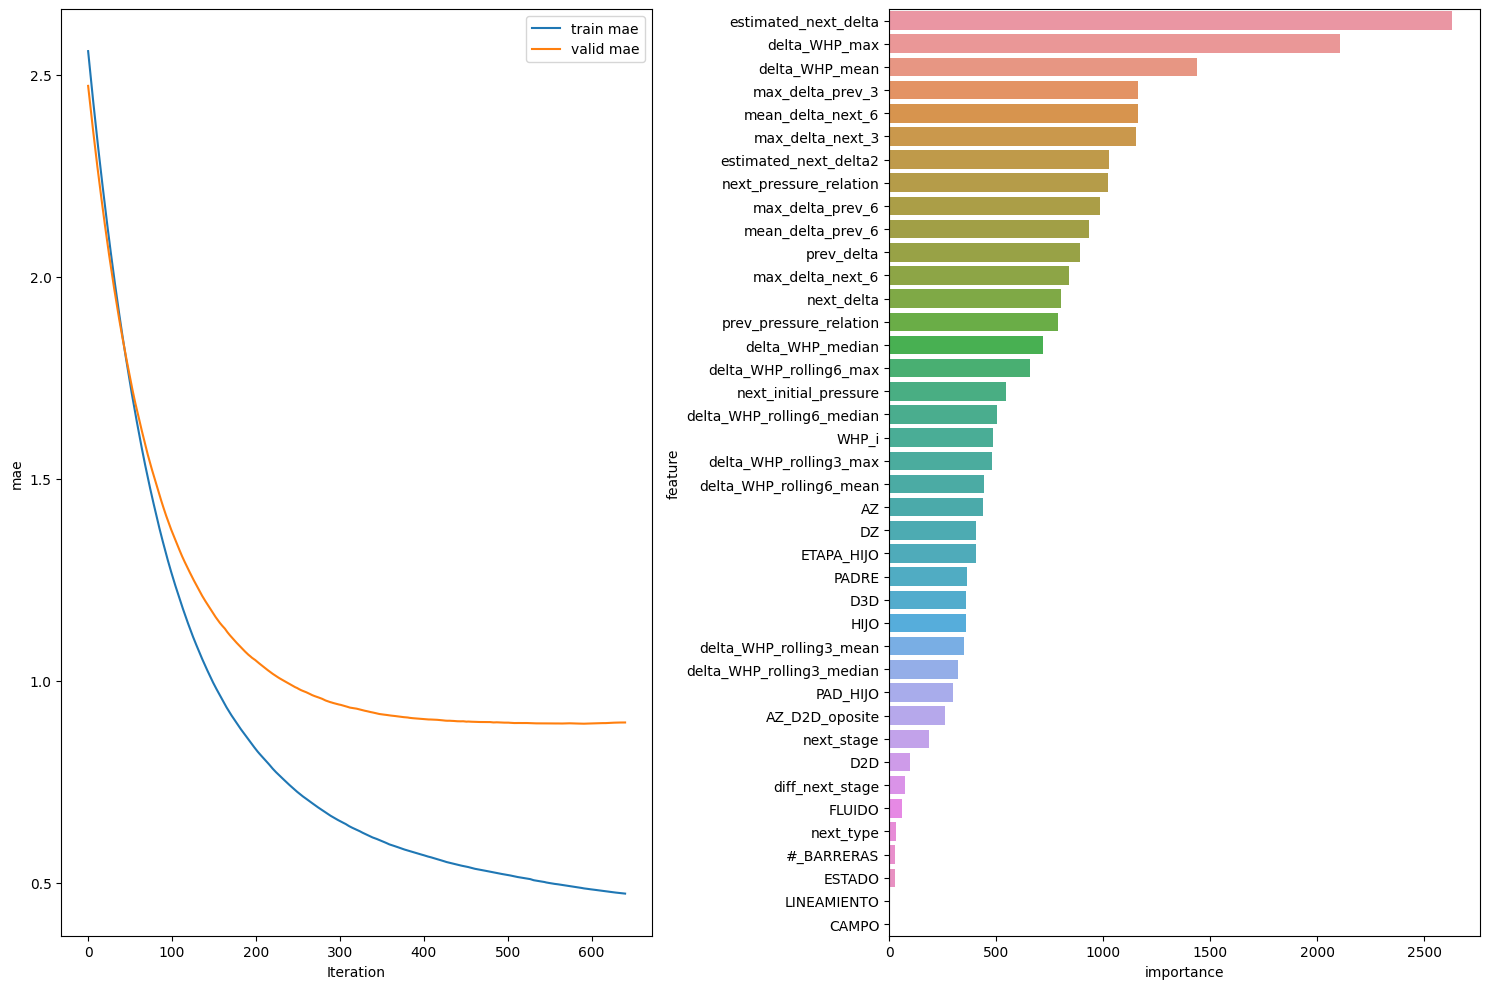

In [50]:
model, preds = validate_model(df[(df.type != 'Test')], target, model_features, params)
# Best MAE: 0.8934
# Best MAE fixed: 0.8250

### Análisis mayores diferencias respecto del target

In [51]:
aux = df[df.type == 'Validation'].reset_index(drop=True)
aux['preds'] = pd.Series(preds, name='preds')
aux['diffReal'] = (aux[target] - aux['preds']).abs()
mae = mean_absolute_error(aux[target], aux['preds'])
print("MAE original:", mae)

MAE original: 0.8934277079278958


In [52]:
def print_real_vs_preds(aux):
    fig = px.scatter(
        aux,
        x=aux[target],
        y=aux['preds'],
        labels={'x': 'real', 'y': 'prediction'},
        hover_data=[
            'CAMPO',
            'PAD_HIJO',
            'PADRE',
            'HIJO',
            'ETAPA_HIJO',
        ],
    )
    fig.add_shape(
        type="line",
        line=dict(dash='dash'),
        x0=aux[target].min(),
        y0=aux[target].min(),
        x1=aux[target].max(),
        y1=aux[target].max(),
    )
    fig.show()


print_real_vs_preds(aux)

> En este gráfico se observan dos problemas a la hora de realizar predicciones,

1. las predicciones distintas de 0 cuyo valor real es 0
2. las predicciones de deltas elevedos (>50) son subestimadas por el modelo

1. Evaluación mae para corrección de predicciones cercanas a 0

In [53]:
def return_opt_cut(aux):
    results = pd.DataFrame(columns=['step', 'mae'])
    for i in np.arange(0.0, 3.0, 0.1):
        current_fix = aux.copy()
        current_fix.loc[abs(current_fix.preds) < i, 'preds'] = 0.0
        results = pd.concat(
            [
                results,
                pd.DataFrame(
                    {
                        'step': [i],
                        'mae': [
                            mean_absolute_error(
                                current_fix[target], current_fix['preds']
                            )
                        ],
                    }
                ),
            ]
        )

    fig = px.scatter(
        results, x=results['step'], y=results['mae'], labels={'x': 'step', 'y': 'mae'}
    )
    fig.show()

    return results.loc[results.mae == results.mae.min(), 'step'].values[0]


group_list = ['CAMPO', 'cut_off_dad', 'cut_off_child', 'cut_off_pad']

optimal_cuts = aux.groupby(group_list).apply(return_opt_cut)
optimal_cuts = optimal_cuts.rename('optimal_cut')
optimal_cuts = optimal_cuts.reset_index()
optimal_cuts

CAMPO  cut_off_dad  cut_off_child  cut_off_pad  optimal_cut
0   Campo A        False          False        False        0.400
1   Campo A        False           True        False        1.000
2   Campo B        False          False        False        2.400
3   Campo B        False           True        False        0.100
4   Campo C        False          False        False        0.300
5   Campo C        False           True        False        1.300
6   Campo C        False           True         True        0.100
7   Campo C         True          False        False        1.800
8   Campo C         True           True        False        2.000
9   Campo C         True           True         True        2.900
10  Campo D        False          False         True        2.600
11  Campo D        False           True         True        1.300
12  Campo D         True          False         True        1.700
13  Campo D         True           True         True        1.500
14  Campo E        False           True         True        2.900
15  Campo E         True           True         True        2.700
16  Campo F        False           True         True        1.700
17  Campo F         True          False         True        0.300
18  Campo F         True           True         True        2.900
19  Campo G         True           True         True        2.500
20  Campo H         True           True         True        0.100
21  Campo I         True           True         True        0.100

Para cada sección determinamos el umbral de corte óptimo, esto es utilizado para pasar a cero casos de forma mas óptima

In [54]:
aux = aux.merge(optimal_cuts, on=group_list, how='left')
aux.loc[abs(aux.preds) < aux.optimal_cut, 'preds'] = 0.0
mae = mean_absolute_error(aux[target], aux['preds'])
print("MAE fixed:", mae)

MAE fixed: 0.8250962162383061


El fix original solo tomaba un umbral de corte fijo, y este era peor:

In [55]:
aux = df[df.type == 'Validation'].reset_index(drop=True)
aux['preds'] = pd.Series(preds, name='preds')
aux['diffReal'] = (aux[target] - aux['preds']).abs()
mae = mean_absolute_error(aux[target], aux['preds'])
print("MAE original:", mae)
aux.loc[abs(aux.preds) < 2.5, 'preds'] = 0.0
mae = mean_absolute_error(aux[target], aux['preds'])
print("MAE fixed:", mae)

MAE original: 0.8934277079278958
MAE fixed: 0.8337050098615986


2. Deltas > 50 subestimados

Aquí no podemos mejorar el score ya que dentro de las predicciones arrojadas no hay un patron de corte claro (estan distribuidas entre todos los valores), por lo cual una mejora posible para el modelo es agregar variables que ayuden a detectar mejor estos eventos

In [56]:
# Mayores diferencias
aux[['CAMPO','PAD_HIJO','HIJO','ETAPA_HIJO','PADRE','delta_WHP','preds','diffReal']].sort_values(by='diffReal', ascending=False).head(10)

CAMPO PAD_HIJO      HIJO  ETAPA_HIJO     PADRE  delta_WHP   preds  \
6815  Campo F   PAD-80  Pozo 265          37   Pozo 15    152.900   0.000   
1773  Campo G   PAD-91  Pozo 572          24  Pozo 436    -90.000  53.284   
7772  Campo F   PAD-87  Pozo 563           7  Pozo 290    119.700   0.000   
5336  Campo F   PAD-63   Pozo 85           3  Pozo 267    212.800 102.512   
3169  Campo D   PAD-53  Pozo 160           4  Pozo 157    127.500  32.065   
1768  Campo G   PAD-91  Pozo 572           1  Pozo 436     26.000  94.158   
7853  Campo F   PAD-83  Pozo 546           4  Pozo 382     10.000  70.004   
1776  Campo G   PAD-91  Pozo 573          16  Pozo 436     62.600   2.840   
3123  Campo D   PAD-50  Pozo 190           2   Pozo 57     75.000  16.140   
5341  Campo F   PAD-63   Pozo 85          18  Pozo 267      0.000  53.609   

      diffReal  
6815   152.893  
1773   143.284  
7772   118.816  
5336   110.288  
3169    95.435  
1768    68.158  
7853    60.004  
1776    59.760  
3123    58.860  
5341    53.609

In [57]:
# Menores diferencias
aux.loc[aux.diffReal > 0,['CAMPO','PAD_HIJO','HIJO','ETAPA_HIJO','PADRE','delta_WHP','preds','diffReal']].sort_values(by='diffReal', ascending=False).tail(10)

CAMPO PAD_HIJO      HIJO  ETAPA_HIJO     PADRE  delta_WHP  preds  \
507   Campo C   PAD-21  Pozo 478          17  Pozo 101      0.000  0.000   
1804  Campo G   PAD-91  Pozo 573          26  Pozo 437      0.000  0.000   
3386  Campo E   PAD-69  Pozo 324          24  Pozo 310      0.000  0.000   
6707  Campo F   PAD-79  Pozo 313           6  Pozo 310      0.000  0.000   
5542  Campo F   PAD-66  Pozo 394          29  Pozo 284      0.000  0.000   
2212  Campo B    PAD-6   Pozo 32          54   Pozo 66      0.000  0.000   
3523  Campo E   PAD-72  Pozo 316           1  Pozo 314      0.000  0.000   
806   Campo C   PAD-23  Pozo 481           6  Pozo 135      0.000  0.000   
5346  Campo F   PAD-63   Pozo 85          11  Pozo 268      0.000  0.000   
4677  Campo F   PAD-59  Pozo 231          19  Pozo 228      0.000  0.000   

      diffReal  
507      0.000  
1804     0.000  
3386     0.000  
6707     0.000  
5542     0.000  
2212     0.000  
3523     0.000  
806      0.000  
5346     0.000  
4677     0.000

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">6 | Entrenamiento Modelo</div>

In [58]:
# reload data
train_df, eval_df, df = read_data()
df = fe(df)

Calculating delta_WHP aggregations for _rolling6_..
	delta_WHP_rolling6_max
	delta_WHP_rolling6_mean
	delta_WHP_rolling6_median
Calculating delta_WHP aggregations for _rolling6_..
	delta_WHP_rolling6_max_next
	delta_WHP_rolling6_mean_next
	delta_WHP_rolling6_median_next
Calculating delta_WHP aggregations for _rolling3_..
	delta_WHP_rolling3_max
	delta_WHP_rolling3_mean
	delta_WHP_rolling3_median
Calculating delta_WHP aggregations for _rolling3_..
	delta_WHP_rolling3_max_next
	delta_WHP_rolling3_mean_next
	delta_WHP_rolling3_median_next
Calculating WHP_i aggregations for _rolling1_..
	WHP_i_rolling1_min_next


In [59]:
def train_final(df, num_rounds, feat_cols, target_col, params):
    """Entrenamiento del modelo final.

    Args:
        df (pd.DataFrame): set de datos full
        num_rounds (int): numero de iteraciones
        feat_cols (list): lista de features del modelo
        target_col (str): nombre del target
        params (dict): parametros de entrenamiento

    Returns:
        Booster: model
    """
    list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
    for str_obj_col in list_str_obj_cols:
        df[str_obj_col] = df[str_obj_col].astype("category")

    train_filter = df.type.isin(['Train', 'Validation'])
    X_train, y_train = df.loc[train_filter, feat_cols], df.loc[train_filter, target_col]
    gbm = lgb.train(params, lgb.Dataset(X_train, y_train), num_boost_round=num_rounds)
    return gbm


model_final = train_final(df, model.best_iteration, model_features, target, params)

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">7 | Inferencia</div>

In [60]:
def predict(df, header_cols, feat_cols, target_col, model):
    """Calculo de predicciones.

    Args:
        df (pd.DataFrame): set de datos full
        feat_cols (list): lista de features del modelo
        model (Booster): modelo para realizar predicciones

    Returns:
        pd.DataFrame: set de datos con algunas variables y su prediccion final
    """
    to_infer_filter = df.type == 'Test'
    to_infer = df.loc[to_infer_filter, feat_cols]

    result = df.loc[to_infer_filter, header_cols + feat_cols]
    result[target_col] = model.predict(to_infer)

    return result


submission = predict(df, header_cols, model_features, target, model_final)

submission.head()

ID_FILA           ID_EVENTO  type  cut_off_dad  cut_off_child  \
4     29868  Pozo 462-Pozo 1-20  Test        False           True   
6     29811  Pozo 462-Pozo 1-24  Test        False           True   
9     29810  Pozo 462-Pozo 1-30  Test        False           True   
10    29867  Pozo 463-Pozo 1-16  Test        False           True   
23    31198  Pozo 461-Pozo 4-14  Test        False           True   

    cut_off_pad    CAMPO FLUIDO PAD_HIJO      HIJO   PADRE  ETAPA_HIJO  \
4         False  Campo A    GAS    PAD-1  Pozo 462  Pozo 1          20   
6         False  Campo A    GAS    PAD-1  Pozo 462  Pozo 1          24   
9         False  Campo A    GAS    PAD-1  Pozo 462  Pozo 1          30   
10        False  Campo A    GAS    PAD-1  Pozo 463  Pozo 1          16   
23        False  Campo A    GAS    PAD-1  Pozo 461  Pozo 4          14   

        D3D     D2D     DZ      AZ  #_BARRERAS LINEAMIENTO   WHP_i   ESTADO  \
4   517.448 515.958 39.238 266.627           1          NO 110.600  Abierto   
6   527.768 526.164 41.115 275.908           1          NO 105.700  Abierto   
9   511.392 509.709 41.456 276.685           1          NO 105.700  Abierto   
10 9999.000   0.000  0.000   0.000           0          NO 110.400  Abierto   
23  569.158 569.150 -3.072 219.947           0          NO 264.600  Cerrado   

    AZ_D2D_oposite  prev_pressure_relation  prev_delta  max_delta_prev_3  \
4          515.064                     NaN         NaN               NaN   
6          523.370                   0.977      -2.700            -2.700   
9          506.243                   0.995      -3.700             5.800   
10           0.000                     NaN         NaN               NaN   
23         365.439                   1.040      -2.200            -1.700   

    max_delta_prev_6  mean_delta_prev_6  delta_WHP_rolling6_max  \
4                NaN                NaN                   4.000   
6             -2.700             -2.700                   5.800   
9              5.800             -0.200                   5.800   
10               NaN                NaN                   4.000   
23            34.000              3.533                   6.200   

    delta_WHP_rolling6_mean  delta_WHP_rolling6_median  \
4                    -1.060                     -1.600   
6                     4.167                      3.600   
9                     4.167                      3.600   
10                   -1.100                     -1.450   
23                    2.583                      3.050   

    delta_WHP_rolling3_max  delta_WHP_rolling3_mean  \
4                   -1.300                   -2.000   
6                    5.800                    4.167   
9                    3.600                    3.350   
10                  -1.300                   -1.867   
23                   6.200                    1.100   

    delta_WHP_rolling3_median  next_initial_pressure  next_stage next_type  \
4                      -2.000                108.200      22.000     Train   
6                       3.600                103.500      28.000     Train   
9                       3.350                    NaN         NaN      Test   
10                     -1.600                106.000      30.000     Train   
23                     -1.200                241.400      15.000     Train   

    diff_next_stage  estimated_next_delta  estimated_next_delta2  \
4             2.000                   NaN                224.000   
6             4.000                   NaN                  0.000   
9               NaN                   NaN                  0.200   
10           14.000                   NaN                  0.200   
23            1.000               -23.200                  0.800   

    next_pressure_relation  next_delta  max_delta_next_3  max_delta_next_6  \
4                    0.978      -2.700             5.800             5.800   
6                    0.979       5.800             5.800             5.800   
9                

### Fixes sobre file de submission

In [61]:
submission = submission.merge(optimal_cuts, on=group_list, how='left')
submission.loc[abs(submission[target]) < submission.optimal_cut, target] = 0.0

### Guardando solución

In [62]:
submission[['ID_FILA', target]].to_csv(
    submission_folder + 'submit_' + version + '.csv', index=False, header=False
)


> Este modelo dio 0.6758 de score, 1 puesto hasta el momento!!

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">8 | Conclusiones</div>


1. Este modelo no está preparado para un entorno productivo, fue pensado y desarrollado sólo considerando lo mejor en términos predictivos para la competencia tal cual fue planteada

2. De la mano con lo anterior se usaron adrede variables que representan el estado del pozo en el futuro para incrementar el poder predictivo del algoritmo

2. Si bien la idea original era implementar otra métrica relacionada a minimizar el aseguramiento de pozos que no lo necesitan o justamente lo contrario, sufrir variaciones en pozos no asegurados, el actual modelo se optimiza con la métrica presentada en la plataforma que es el MAE

3. Se pueden aportar mejores soluciones incorporando data temporal (jugamos con muchas variables para determinar el orden de los eventos pero seria mucho mejor tener el momento concreto en que pasaron), y data de geolocalización de los pozos

4. Desde ya disfrute la competencia me gusto la dinámica y el nivel de participación y me encantaría poder aportar a un proyecto tan importante para el país como es Vaca Muerta pero ya desde una perspectiva mucho mas profesional y realmente orientada a solucionar problema reales

